In [1]:
# Set random seed before any other imports
# Particularly important to be able to reproduce results in Keras
import os
import random
import numpy as np
import tensorflow as tf

random_seed = 100

def reset_seeds():
  os.environ["PYTHONHASHSEED"] = str(random_seed)
  np.random.seed(random_seed) 
  random.seed(random_seed)
  tf.random.set_seed(random_seed)

reset_seeds()

<h1>DSBA 2020 Final Exam: Predicting cancellations in the hotel industry</h1>

Data Science for Business Applications (CDSCV1003U) @ CBS

<i>Christina E. Haagh (Sxxxxxx), Anders A. Lauridsen (Sxxxxxx) and Esben H. Vestergaard (Sxxxxxx)</i>

In [2]:
# Start by upgrading plotly
!pip install --upgrade plotly

     |████████████████████████████████| 13.1MB 237kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [3]:
# Import pandas, NumPy and visualization packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
import scipy
from datetime import datetime

sns.set(color_codes=True)

In [4]:
# Set random seed to be used throughout the notebook
random_seed = 100

In [5]:
# Load the two CSV files from our GitHub repo

# Resort Hotel dataset
H1 = pd.read_csv("https://team-dsba.github.io/hotel-bookings/data/H1.csv")

# City Hotel dataset
H2 = pd.read_csv("https://team-dsba.github.io/hotel-bookings/data/H2.csv")

In [6]:
# Add a column with the respective hotel type in each dataset
H1.insert(0, "hotel", "Resort Hotel")
H2.insert(0, "hotel", "City Hotel")

# Merging the data
df = H1.append(H2, ignore_index=True) 

# Rename columns for our own convention:
# Lowercase and underscores as separators
df.columns = [
    "hotel",
    "is_canceled",
    "lead_time",
    "arrival_date_year",
    "arrival_date_month",
    "arrival_date_week_number",
    "arrival_date_day_of_month",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "meal",
    "country",
    "market_segment",
    "distribution_channel",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "reserved_room_type",
    "assigned_room_type",
    "booking_changes",
    "deposit_type",
    "agent",
    "company",
    "days_in_waiting_list",
    "customer_type",
    "adr",
    "required_car_parking_spaces",
    "total_of_special_requests",
    "reservation_status",
    "reservation_status_date"
]

In [7]:
# Display 5 first and last 5 instances of DF
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [8]:
# Display info about variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

*Whitespaces in several column values*

Before we can commence the actual pre-processing, we need to correct some of the values in the original dataset. Several variables have unintended trailing whitespaces.

In [9]:
# Some column values have trailing whitespaces
# Example:
df["meal"].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'Undefined'],
      dtype=object)

In [10]:
# Let's remove that using strip
df["meal"] = df["meal"].str.strip()
df["reserved_room_type"] = df["reserved_room_type"].str.strip()
df["assigned_room_type"] = df["assigned_room_type"].str.strip()
df["deposit_type"] = df["deposit_type"].str.strip()
df["agent"] = df["agent"].str.strip()
df["company"] = df["company"].str.strip()

# Convert NULL to actual NumPy NaNs
df["agent"].replace("NULL", np.nan, inplace=True)
df["company"].replace("NULL", np.nan, inplace=True)

In [11]:
# Check that it has worked
df["meal"].unique()

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

# Data preprocessing and exploration

## Data cleaning

### Dealing with missing and overlapping values

**Missing values**

In [12]:
# Check missing values within each column
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [13]:
# Create a copy on original DF to contain preprocessing adjustments
df_modified = df.copy()

In [14]:
# Drop rows with NaN values in columns children and country
df_modified.dropna(subset=["children", "country"], inplace=True)

In [15]:
# Replace NaN values with None in columns agent and company
df_modified["agent"].replace(np.nan, "None", regex=True, inplace=True)
df_modified["company"].replace(np.nan, "None", regex=True, inplace=True)

**Incorrect and overlapping values**

We have identified a number of corrections to be made by applying the `.unique()` method to each column and looking for incorrect, missing or overlapping values.

*Country: Overlapping values*

In [16]:
# Display unique values of country
df_modified["country"].unique()

array(['PRT', 'GBR', 'USA', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'OMN',
       'ARG', 'POL', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'ITA', 'NLD',
       'DNK', 'RUS', 'SWE', 'AUS', 'EST', 'CZE', 'BRA', 'FIN', 'MOZ',
       'BWA', 'LUX', 'SVN', 'ALB', 'IND', 'CHN', 'MEX', 'MAR', 'UKR',
       'SMR', 'LVA', 'PRI', 'SRB', 'CHL', 'AUT', 'BLR', 'LTU', 'TUR',
       'ZAF', 'AGO', 'ISR', 'CYM', 'ZMB', 'CPV', 'ZWE', 'DZA', 'KOR',
       'CRI', 'HUN', 'ARE', 'TUN', 'JAM', 'HRV', 'HKG', 'IRN', 'GEO',
       'AND', 'GIB', 'URY', 'JEY', 'CAF', 'CYP', 'COL', 'GGY', 'KWT',
       'NGA', 'MDV', 'VEN', 'SVK', 'FJI', 'KAZ', 'PAK', 'IDN', 'LBN',
       'PHL', 'SEN', 'SYC', 'AZE', 'BHR', 'NZL', 'THA', 'DOM', 'MKD',
       'MYS', 'ARM', 'JPN', 'LKA', 'CUB', 'CMR', 'BIH', 'MUS', 'COM',
       'SUR', 'UGA', 'BGR', 'CIV', 'JOR', 'SYR', 'SGP', 'BDI', 'SAU',
       'VNM', 'PLW', 'QAT', 'EGY', 'PER', 'MLT', 'MWI', 'ECU', 'MDG',
       'ISL', 'UZB', 'NPL', 'BHS', 'MAC', 'TGO', 'TWN', 'DJI', 'STP',
       'KNA', 'ETH', 

In [17]:
# Replace CN with CHN
df_modified["country"].replace("CN", "CHN", inplace=True)

*Meal: Overlapping values*

In [18]:
# Display unique values of meal
df_modified["meal"].unique()

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

In [19]:
# According to data source, values SC and Undefined both mean "no meal package".
# We therefore replace Undefined with SC
df_modified["meal"].replace("Undefined", "SC", inplace=True)

In [20]:
# Display unique values of meal
df_modified["meal"].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

*Distribution channel: Missing values*

In [21]:
# Display count of unique values of distribution_channel
df_modified["distribution_channel"].value_counts()

TA/TO        97730
Direct       14483
Corporate     6491
GDS            193
Undefined        1
Name: distribution_channel, dtype: int64

In [22]:
# Subset all rows that do not have Undefined as value in distribution_channel
df_modified = df_modified[df_modified["distribution_channel"] != "Undefined"]

*ADR: Incorrect (negative) values*

In [23]:
# Let us have a look at the numerical variable ADR (Average Daily Rate)
df_modified["adr"].describe()

count    118897.000000
mean        102.003153
std          50.486065
min          -6.380000
25%          70.000000
50%          95.000000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64

In [24]:
# See the number of instances with a negative ADR
df_modified[df_modified["adr"] < 0]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
14969,Resort Hotel,0,195,2017,March,10,5,4,6,2,0.0,0,BB,GBR,Groups,Direct,1,0,2,A,H,2,No Deposit,273,None,0,Transient-Party,-6.38,0,0,Check-Out,2017-03-15


In [25]:
# Subset data where ADR is equal to or above 0
df_modified = df_modified[df_modified["adr"] >= 0]

### Correcting data types

In [26]:
# Display data types of all columns
df_modified.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [27]:
# Correct data types for certain columns
# object = categorical data
df_modified = df_modified.astype({
    "is_canceled": "object",
    "arrival_date_year": "object",
    "arrival_date_week_number": "object",
    "arrival_date_day_of_month": "object",
    "children": "int64",
    "is_repeated_guest": "object",
    "agent": "object",
    "company": "object"
})

**Our final, modified dataset now looks as follows**

In [28]:
df_modified.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118896 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118896 non-null  object 
 1   is_canceled                     118896 non-null  object 
 2   lead_time                       118896 non-null  int64  
 3   arrival_date_year               118896 non-null  object 
 4   arrival_date_month              118896 non-null  object 
 5   arrival_date_week_number        118896 non-null  object 
 6   arrival_date_day_of_month       118896 non-null  object 
 7   stays_in_weekend_nights         118896 non-null  int64  
 8   stays_in_week_nights            118896 non-null  int64  
 9   adults                          118896 non-null  int64  
 10  children                        118896 non-null  int64  
 11  babies                          118896 non-null  int64  
 12  meal            

## Initial data exploration

### Exploring categorical variables

**Distribution of nationalities**

In [29]:
# Make a new DF with our plot data
country_plot = pd.DataFrame()

# Make a column for each country and a column with the value count for each country
country_plot["country"] = df_modified["country"].value_counts().index
country_plot["bookings_count"] = df_modified["country"].value_counts().values

# Calculate percent for each row
# Then replace value for column country with Other if below 1%
country_plot["bookings_pct"] = country_plot["bookings_count"].apply(lambda x: x / country_plot["bookings_count"].sum())
country_plot.loc[country_plot["bookings_pct"] < 0.01, "country"] = "Other"

# Make pie chart using plotly express
fig = px.pie(country_plot, values="bookings_count", names="country", title="Distribution of nationalities", template="seaborn", color_discrete_sequence=px.colors.sequential.dense)
fig.update_traces(textinfo="value+percent+label", textposition="inside")
fig.show()

**Distribution of cancellations**

In [30]:
# Make a new DF with our plot data
cancelation_plot = pd.DataFrame()

# Make a column for each country and a column with the value count for each country
cancelation_plot["is_canceled"] = df_modified["is_canceled"].value_counts().index
cancelation_plot["is_canceled_count"] = df_modified["is_canceled"].value_counts().values

#replacing 0 and 1 with canceled and not_canceled
cancelation_plot["is_canceled"].replace(0, "Not canceled (0)", inplace=True)
cancelation_plot["is_canceled"].replace(1, "Canceled (1)", inplace=True)

# Calculate percent for each row
# Then replace value for column country with Other if below 1%
cancelation_plot["is_canceled_pct"] = cancelation_plot["is_canceled_count"].apply(lambda x: x / cancelation_plot["is_canceled_count"].sum())

# Make pie chart using plotly express
fig = px.pie(cancelation_plot, values="is_canceled_count", names="is_canceled", title="Distribution of cancellations", template="seaborn", color_discrete_sequence=px.colors.sequential.dense)
fig.update_traces(textinfo="value+percent+label", textposition="inside")
fig.show()

**Distribution of customer types**

In [31]:
# Make a new DF with our plot data
customer_type_plot = pd.DataFrame()

# Make a column for each country and a column with the value count for each country
customer_type_plot["customer_type"] = df_modified["customer_type"].value_counts().index
customer_type_plot["customer_type_count"] = df_modified["customer_type"].value_counts().values

# Calculate percent for each row
# Then replace value for column country with Other if below 1%
customer_type_plot["is_canceled_pct"] = customer_type_plot["customer_type_count"].apply(lambda x: x / customer_type_plot["customer_type_count"].sum())
customer_type_plot.loc[customer_type_plot["is_canceled_pct"] < 0.05, "customer_type"] = "Other"

# Make pie chart using plotly express
fig = px.pie(customer_type_plot, values="customer_type_count", names="customer_type", title="Distribution of customer types", template="seaborn", color_discrete_sequence=px.colors.sequential.dense)
fig.update_traces(textinfo="value+percent+label", textposition="inside")
fig.show()

**Distribution of distribution channels**

In [32]:
# Make a new DF with our plot data
distribution_channel_plot = pd.DataFrame()

# Make a column for each country and a column with the value count for each country
distribution_channel_plot["distribution_channel"] = df_modified["distribution_channel"].value_counts().index
distribution_channel_plot["distribution_channel_count"] = df_modified["distribution_channel"].value_counts().values

#Make TA/TO Travel Agent/Tour Operator
distribution_channel_plot["distribution_channel"].replace("TA/TO", "Travel Agent/Tour Operator", inplace=True)

# Calculate percent for each row
# Then replace value for column country with Other if below 1%
distribution_channel_plot["distribution_channel_pct"] = distribution_channel_plot["distribution_channel_count"].apply(lambda x: x / distribution_channel_plot["distribution_channel_count"].sum())
distribution_channel_plot.loc[distribution_channel_plot["distribution_channel_pct"] < 0.05, "distribution_channel"] = "Other"

# Make pie chart using plotly express
fig = px.pie(distribution_channel_plot, values="distribution_channel_count", names="distribution_channel", title="Distribution distribution channels", template="seaborn", color_discrete_sequence=px.colors.sequential.dense)
fig.update_traces(textinfo="value+percent+label", textposition="inside")
fig.show()

### Exploring the numerical variables

**Summary statistics**

In [33]:
df_stat = pd.DataFrame(df_modified.describe().T)
del df_stat['count']
df_stat

,mean,std,min,25%,50%,75%,max
lead_time,104.310683,106.903885,0.0,18.0,69.0,161.0,737.0
stays_in_weekend_nights,0.928862,0.996180,0.0,0.0,1.0,2.0,16.0
stays_in_week_nights,2.502111,1.900156,0.0,1.0,2.0,3.0,41.0
adults,1.858389,0.578580,0.0,2.0,2.0,2.0,55.0
children,0.104200,0.399167,0.0,0.0,0.0,0.0,10.0
babies,0.007948,0.097381,0.0,0.0,0.0,0.0,10.0
previous_cancellations,0.087143,0.845876,0.0,0.0,0.0,0.0,26.0
previous_bookings_not_canceled,0.131619,1.484674,0.0,0.0,0.0,0.0,72.0
booking_changes,0.221168,0.652770,0.0,0.0,0.0,0.0,21.0
days_in_waiting_list,2.330793,17.630598,0.0,0.0,0.0,0.0,391.0


**Correlation between numerical values**

Text(0.5, 1.0, 'Correlation between numerical variables')

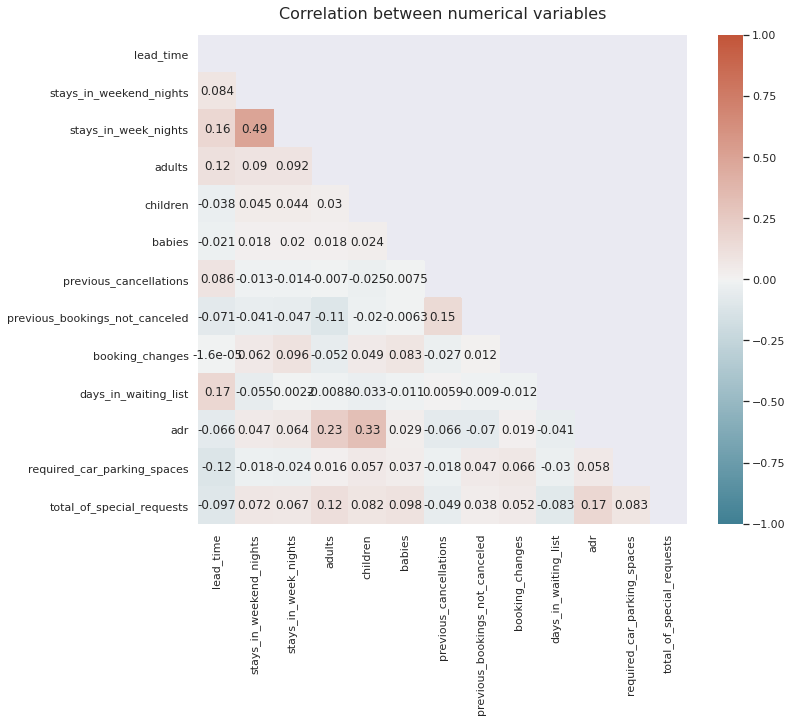

In [34]:
# Select numerical variables
numerical_variables = df_modified.select_dtypes(include=["int64", "float64"])

# Compute the correlation matrix
corr = numerical_variables.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, square=True, linewidth=0)
heatmap.set_title("Correlation between numerical variables", fontdict={"fontsize": 16}, pad=16)

### Arrival date

Let's investigate which months are the most busy on average. We already have a row containing the arrival month.

However, the data spans from **July 2015** until **August 2017** (as can be seen in the table below). Therefore, some months are more prevalent than others. We need to take this into account when calculating an average.

In [35]:
# Show observations per month in each year
ordered_months = pd.to_datetime(df["arrival_date_month"], format="%B", errors="coerce").dt.month.sort_values() # Sort months in numerical order
pd.crosstab(ordered_months, df_modified["arrival_date_year"]) # Crosstab

arrival_date_year,2015,2016,2017
arrival_date_month,,,
1,0,2215,3659
2,0,3857,4155
3,0,4788,4950
4,0,5404,5641
5,0,5466,6313
6,0,5280,5647
7,2762,4552,5313
8,3873,5054,4925
9,5084,5383,0


In [36]:
# Subset data on Resort and City hotel
df_rh = df_modified[df_modified["hotel"] == "Resort Hotel"]
df_ch = df_modified[df_modified["hotel"] == "City Hotel"]

# Count monthly bookings for Resort Hotel
arrival_plot_rh = pd.DataFrame({
    "arrival_date_month": df_rh["arrival_date_month"].value_counts().index,
    "bookings_count": df_rh["arrival_date_month"].value_counts().values,
    "hotel": "Resort Hotel"
})

# Count monthly bookings for City Hotel
arrival_plot_ch = pd.DataFrame({
    "arrival_date_month": df_ch["arrival_date_month"].value_counts().index,
    "bookings_count": df_ch["arrival_date_month"].value_counts().values,
    "hotel": "City Hotel"
})

# Merge the two DFs
arrival_plot = pd.concat([arrival_plot_rh, arrival_plot_ch], ignore_index=True)

# Divide counts for July and August by 3 to get average, whereas the other months we only divide by 2
def month_divider(row):
  special_months = ["July", "August"]
  if row["arrival_date_month"] in special_months:
    month_avg = row["bookings_count"] / 3
  else:
    month_avg = row["bookings_count"] / 2
  
  return month_avg

arrival_plot["bookings_count_avg"] = arrival_plot.apply(month_divider, axis=1)

# Order the DF by months
months_ordered = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
arrival_plot["arrival_date_month"] = pd.Categorical(arrival_plot["arrival_date_month"], categories=months_ordered, ordered=True)

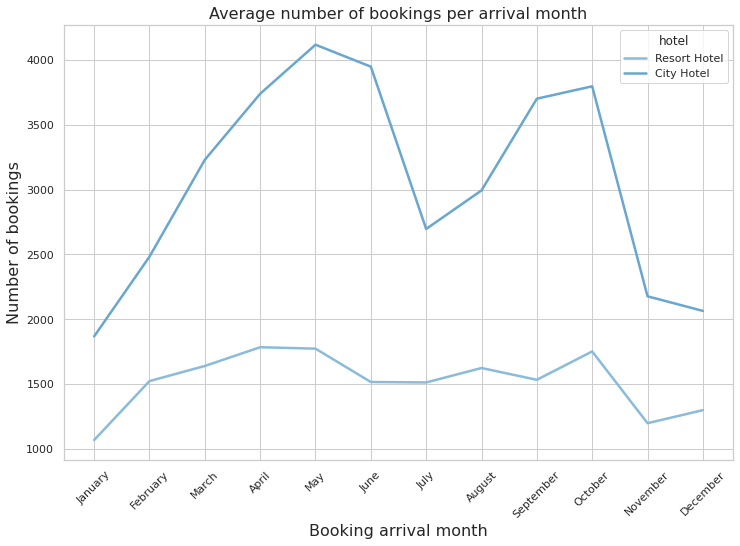

In [37]:
# Make a line plot of the bookings per arrival month using seaborn
sns.set(style="whitegrid", palette="Blues_d")
plt.figure(figsize=(12, 8))
sns.lineplot(data=arrival_plot, x="arrival_date_month", y="bookings_count_avg", hue="hotel", size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of bookings per arrival month", fontsize=16)
plt.xlabel("Booking arrival month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of bookings", fontsize=16)
plt.show()

### ADR

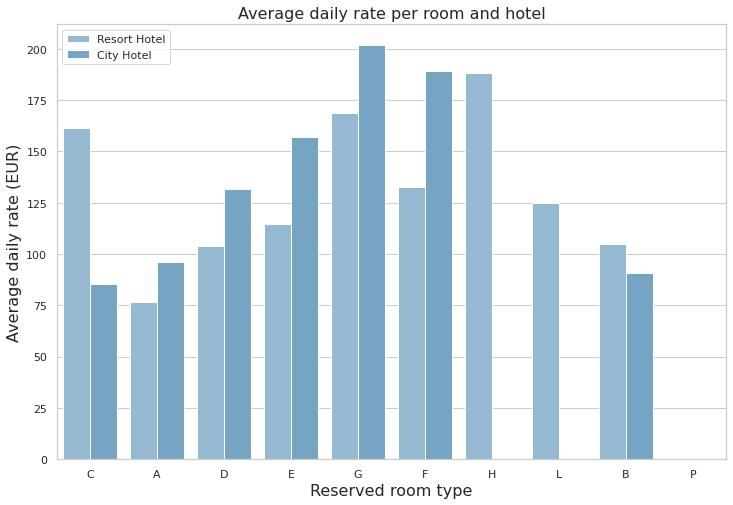

In [38]:
sns.set(style="whitegrid", palette="Blues_d")
plt.figure(figsize=(12, 8))
sns.barplot(x='reserved_room_type',
            y="adr",
            hue='hotel',
            data=df_modified, ci=None)
plt.title("Average daily rate per room and hotel", fontsize=16)
plt.xlabel("Reserved room type", fontsize=16)
plt.ylabel("Average daily rate (EUR)", fontsize=16)
plt.legend(loc="upper left")
plt.show()

## Data preparation for Machine Learning

In this section we will:

1. Reduce dataset in order to minimize training time
2. Define target variable
3. Select the most importing features for prediction
4. Prepare the features for ML
5. Split the data into train/test sets


### Reducing dataset

In [39]:
# Removing irrelevant columns from a logical point of view

df_modified.drop(["reservation_status_date",
                 "reservation_status",
                 "arrival_date_year",
                 "arrival_date_day_of_month",
                 "company"],
                inplace=True, axis=1)

**Deciding on the size of the dataset**

In the following section, we will test how different dataset sizes affect model accuracy - for Logistic regression and XGB - in order to decide how much we can reduce the dataset without compromizing of accuracy. The reason for doing this is that our training time with the whole dataset was unreasonably long.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

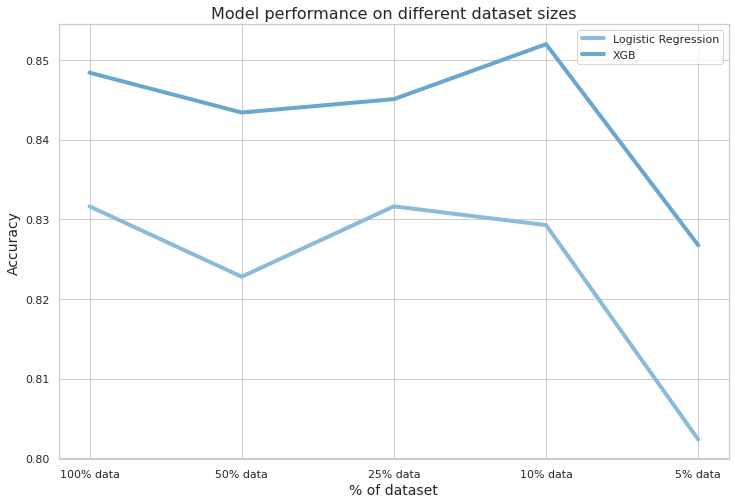

In [40]:
# Defining data sizes to be tested
df_test = df_modified.copy()
test100 = df_test
test50 = df_test.sample(frac=0.5, random_state=random_seed)
test25 = df_test.sample(frac=0.25, random_state=random_seed)
test10 = df_test.sample(frac=0.1, random_state=random_seed)
test5 = df_test.sample(frac=0.05, random_state=random_seed)

# Defining function to test model accuracy
def accuracy_test(data):

  #Defining target
  y = data["is_canceled"]
  from sklearn.preprocessing import LabelEncoder
  labelencoder_y = LabelEncoder()
  y = labelencoder_y.fit_transform(y)
  y = y.flatten()
  
  #Defining features
  x = data.loc[:, data.columns != 'is_canceled']
  
  #Scaling and One-hot encoding
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  num_cols = x.select_dtypes(include=['int64', 'float64']).columns
  x[num_cols] = scaler.fit_transform(x[num_cols])
  x = pd.get_dummies(x, drop_first=True)
  
  #Train/test split
  from sklearn.model_selection import train_test_split
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_seed, stratify=y)
  
  #LR
  from sklearn.linear_model import LogisticRegression
  lr_model_test = LogisticRegression(max_iter=5000, random_state=random_seed)
  lr_model_test.fit(x_train, y_train)
  lr_score_test = lr_model_test.score(x_test, y_test)
  
  #XGB
  from xgboost import XGBClassifier
  xgb_model_test = XGBClassifier(random_state=random_seed)
  xgb_model_test.fit(x_train, y_train)
  xgb_score_test = xgb_model_test.score(x_test, y_test)

  return lr_score_test, xgb_score_test

# Applying the function to the dataset samples
acc_5 = accuracy_test(test5)
acc_10 = accuracy_test(test10)
acc_25 = accuracy_test(test25)
acc_50 = accuracy_test(test50)
acc_100 = accuracy_test(test100)

# Plotting the results
test_results_lr = [acc_100[0], acc_50[0], acc_25[0], acc_10[0], acc_5[0]]
test_results_xgb = [acc_100[1], acc_50[1], acc_25[1], acc_10[1], acc_5[1]]
df_test_result = pd.DataFrame(list(zip(test_results_lr, test_results_xgb)), index =['100% data', '50% data', '25% data', '10% data', '5% data'], 
               columns =['Logistic regression accuracy', 'XGB Accuracy'])

plt.figure(figsize=(12, 8))
plt.plot(df_test_result['Logistic regression accuracy'], linewidth=4)
plt.plot(df_test_result['XGB Accuracy'], linewidth=4)
plt.title("Model performance on different dataset sizes", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("% of dataset", fontsize=14)
plt.legend(["Logistic Regression", "XGB"], loc="upper right")
plt.show()

**Conclusion:** We are going to reduce our dataset to 10% based on above results

In [41]:
# We continue with 10% of our dataset
df_prepared = test10.copy()
df_prepared

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
11214,Resort Hotel,1,23,April,17,1,1,2,2,0,BB,PRT,Online TA,TA/TO,0,0,0,C,C,0,No Deposit,240,0,Transient,125.00,0,0
75689,City Hotel,1,295,August,32,2,2,2,0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,No Deposit,1,0,Transient-Party,62.00,0,0
106829,City Hotel,0,5,February,9,0,4,2,0,0,BB,FRA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,91.80,0,2
13946,Resort Hotel,0,2,November,46,0,1,1,0,0,BB,PRT,Corporate,Direct,0,0,3,A,G,0,No Deposit,None,0,Transient,35.00,0,1
92432,City Hotel,0,145,July,28,2,1,3,0,0,BB,FRA,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,0,Transient,131.70,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40912,City Hotel,0,1,August,33,2,3,2,2,0,SC,AGO,Online TA,TA/TO,0,0,0,F,F,0,No Deposit,9,0,Transient,153.00,0,1
111533,City Hotel,0,139,May,19,1,3,2,1,0,BB,FRA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,144.00,0,2
34360,Resort Hotel,0,19,March,12,0,1,1,0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,I,1,No Deposit,66,0,Transient-Party,45.00,1,0
49523,City Hotel,1,101,April,16,0,3,2,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,None,0,Transient,130.00,0,0


### Defining and label encoding target variable

In [42]:
# Defining target variable
y = df_prepared.pop("is_canceled")

from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

y = y.flatten()
y

array([1, 1, 0, ..., 0, 1, 0])

### Feature importance and selection

In the following, we have made a test of the most influential features using `sklearn`'s feature permutation importance score.

In [43]:
# Make a copy for feature importance scores
df_fi = df_prepared.copy()

In [44]:
# OrdinalEncoding all categorical features
# We do this, so the tree model can read our categorical features

from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

cat_cols = df_fi.select_dtypes(include="object").columns # Selecting only categorical features
df_fi[cat_cols] = oe.fit_transform(df_fi[cat_cols])
df_fi.head()

,hotel,lead_time,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
11214,1.0,23,0.0,16.0,1,1,2,2,0,0.0,86.0,6.0,3.0,0.0,0,0,2.0,2.0,0,0.0,78.0,0,2.0,125.0,0,0
75689,0.0,295,1.0,31.0,2,2,2,0,0,0.0,86.0,4.0,3.0,0.0,1,0,0.0,0.0,0,0.0,0.0,0,3.0,62.0,0,0
106829,0.0,5,3.0,8.0,0,4,2,0,0,0.0,33.0,6.0,3.0,0.0,0,0,0.0,0.0,0,0.0,217.0,0,2.0,91.8,0,2
13946,1.0,2,9.0,45.0,0,1,1,0,0,0.0,86.0,2.0,1.0,0.0,0,3,0.0,6.0,0,0.0,225.0,0,2.0,35.0,0,1
92432,0.0,145,5.0,27.0,2,1,3,0,0,0.0,33.0,6.0,3.0,0.0,0,0,3.0,3.0,0,0.0,217.0,0,2.0,131.7,0,1


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Splitting data and fitting default DecisionTreeClassifier
# We use a tree-based model, as that is able to distinguish between numerical and categorical feature types
X_fi = df_fi.to_numpy()
X_fi_train, X_fi_test, y_fi_train, y_fi_test = train_test_split(X_fi, y, test_size=0.2, random_state=random_seed, stratify=y)
dtc = DecisionTreeClassifier()
dtc_fit = dtc.fit(X_fi_train, y_fi_train)

In [46]:
from sklearn.inspection import permutation_importance

# Generate a permutation score for each feature on the basis of Decision Tree Classifier
r = permutation_importance(dtc_fit, X_fi_train, y_fi_train, n_repeats=10, random_state=random_seed)

In [47]:
# Make a list of all features and their scores
feature_cols = []
feature_imp_mean = []
feature_imp_std = []

for i in r.importances_mean.argsort()[::-1]:
  col = df_fi.columns[i]
  imp_mean = r.importances_mean[i]
  imp_std = r.importances_std[i]

  feature_cols.append(col)
  feature_imp_mean.append(imp_mean)
  feature_imp_std.append(imp_std)

In [48]:
# Display in a DF
feature_list = pd.DataFrame([feature_cols, feature_imp_mean, feature_imp_std]).T
feature_list.columns = ["Variable", "Importance score", "Std. dev."]
feature_list = feature_list.sort_values(by="Importance score", ascending=False)

In [49]:
feature_list

,Variable,Importance score,Std. dev.
0,country,0.202092,0.00313882
1,lead_time,0.177502,0.00463795
2,agent,0.118787,0.00304495
3,market_segment,0.117662,0.00306462
4,total_of_special_requests,0.106791,0.00243113
5,adr,0.104594,0.00279396
6,deposit_type,0.0922834,0.00139297
7,arrival_date_week_number,0.0796468,0.00219579
8,arrival_date_month,0.0393293,0.00119816
9,stays_in_week_nights,0.0387616,0.000714655


### Preparing the features for ML

#### Scaling the features

In [50]:
# Scaling all numerical features

num_cols = df_prepared.select_dtypes(include= ["int64", "float64"]).columns # Selecting only numerical features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_prepared[num_cols] = scaler.fit_transform(df_prepared[num_cols])
df_prepared.head()

,hotel,lead_time,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
11214,Resort Hotel,-0.763023,April,17,0.068468,-0.816755,0.265832,4.673668,-0.083867,BB,PRT,Online TA,TA/TO,0,-0.103278,-0.088315,C,C,-0.346454,No Deposit,240,-0.131555,Transient,0.484557,-0.261316,-0.725365
75689,City Hotel,1.781199,August,32,1.075991,-0.277213,0.265832,-0.253835,-0.083867,BB,PRT,Groups,TA/TO,0,1.054098,-0.088315,A,A,-0.346454,No Deposit,1,-0.131555,Transient-Party,-0.824598,-0.261316,-0.725365
106829,City Hotel,-0.931390,February,9,-0.939056,0.801872,0.265832,-0.253835,-0.083867,BB,FRA,Online TA,TA/TO,0,-0.103278,-0.088315,A,A,-0.346454,No Deposit,9,-0.131555,Transient,-0.205347,-0.261316,1.811652
13946,Resort Hotel,-0.959452,November,46,-0.939056,-0.816755,-1.585804,-0.253835,-0.083867,BB,PRT,Corporate,Direct,0,-0.103278,2.013214,A,G,-0.346454,No Deposit,None,-0.131555,Transient,-1.385664,-0.261316,0.543144
92432,City Hotel,0.378136,July,28,1.075991,-0.816755,2.117468,-0.253835,-0.083867,BB,FRA,Online TA,TA/TO,0,-0.103278,-0.088315,D,D,-0.346454,No Deposit,9,-0.131555,Transient,0.623785,-0.261316,0.543144


#### OneHot encoding

In [51]:
# OneHot encoding categorical features

df_prepared = pd.get_dummies(df_prepared, drop_first=True)
df_prepared.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_Resort Hotel,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_week_number_2,arrival_date_week_number_3,arrival_date_week_number_4,arrival_date_week_number_5,arrival_date_week_number_6,arrival_date_week_number_7,arrival_date_week_number_8,arrival_date_week_number_9,arrival_date_week_number_10,arrival_date_week_number_11,arrival_date_week_number_12,arrival_date_week_number_13,arrival_date_week_number_14,arrival_date_week_number_15,arrival_date_week_number_16,...,agent_531,agent_55,agent_56,agent_57,agent_58,agent_6,agent_63,agent_64,agent_66,agent_67,agent_68,agent_69,agent_7,agent_71,agent_72,agent_74,agent_75,agent_77,agent_78,agent_79,agent_8,agent_82,agent_83,agent_85,agent_86,agent_87,agent_88,agent_89,agent_9,agent_91,agent_93,agent_94,agent_95,agent_96,agent_98,agent_99,agent_None,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
11214,-0.763023,0.068468,-0.816755,0.265832,4.673668,-0.083867,-0.103278,-0.088315,-0.346454,-0.131555,0.484557,-0.261316,-0.725365,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
75689,1.781199,1.075991,-0.277213,0.265832,-0.253835,-0.083867,1.054098,-0.088315,-0.346454,-0.131555,-0.824598,-0.261316,-0.725365,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
106829,-0.931390,-0.939056,0.801872,0.265832,-0.253835,-0.083867,-0.103278,-0.088315,-0.346454,-0.131555,-0.205347,-0.261316,1.811652,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
13946,-0.959452,-0.939056,-0.816755,-1.585804,-0.253835,-0.083867,-0.103278,2.013214,-0.346454,-0.131555,-1.385664,-0.261316,0.543144,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
92432,0.378136,1.075991,-0.816755,2.117468,-0.253835,-0.083867,-0.103278,-0.088315,-0.346454,-0.131555,0.623785,-0.261316,0.543144,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [52]:
# Defining X
X = df_prepared
X = X.to_numpy()
X

array([[-0.76302272,  0.06846753, -0.81675547, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.78119927,  1.07599098, -0.27721313, ...,  0.        ,
         0.        ,  1.        ],
       [-0.93139036, -0.93905592,  0.80187154, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.80043775, -0.93905592, -0.81675547, ...,  0.        ,
         0.        ,  1.        ],
       [-0.03342965, -0.93905592,  0.26232921, ...,  0.        ,
         1.        ,  0.        ],
       [-0.94074411, -0.93905592,  0.26232921, ...,  0.        ,
         1.        ,  0.        ]])

### Splitting data into training and test set

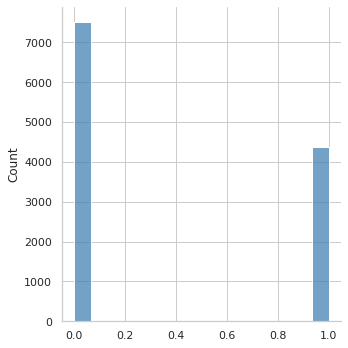

In [53]:
# Checking distribution of target variable

sns.set(style="whitegrid")
sns.displot(y, color="steelblue", kde=False)

We see that the data is not equally distributed between the two target values. Consequently, we have decided to make a stratified split

In [54]:
# Splitting data into test and training set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

# Model training and tuning

In this section, we will train and tune the traditional ML models and the neural networks.






## Traditional ML models

### Training traditional ML models

In [55]:
# Importing the models

# Linear model
from sklearn.linear_model import LogisticRegression

# Non-linear models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Ensemble learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [56]:
# Defining the models

# Linear model
lr_model = LogisticRegression(max_iter=1000, random_state=random_seed)

# Non-linear models
svc_model = SVC(random_state=random_seed)
knn_model = KNeighborsClassifier()
dt_model = DecisionTreeClassifier(random_state=random_seed)

# Ensemble learning models
rf_model = RandomForestClassifier(random_state=random_seed)
bc_model = BaggingClassifier(random_state=random_seed)
et_model = ExtraTreesClassifier(random_state=random_seed)
ab_model = AdaBoostClassifier(random_state=random_seed)
xgb_model = XGBClassifier(random_state=random_seed)

In [57]:
# Fitting the models

# Linear model
lr_model.fit(X_train, y_train)

# Non-linear models
svc_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

# Ensemble learning models
rf_model.fit(X_train, y_train)
bc_model.fit(X_train, y_train)
et_model.fit(X_train, y_train)
ab_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

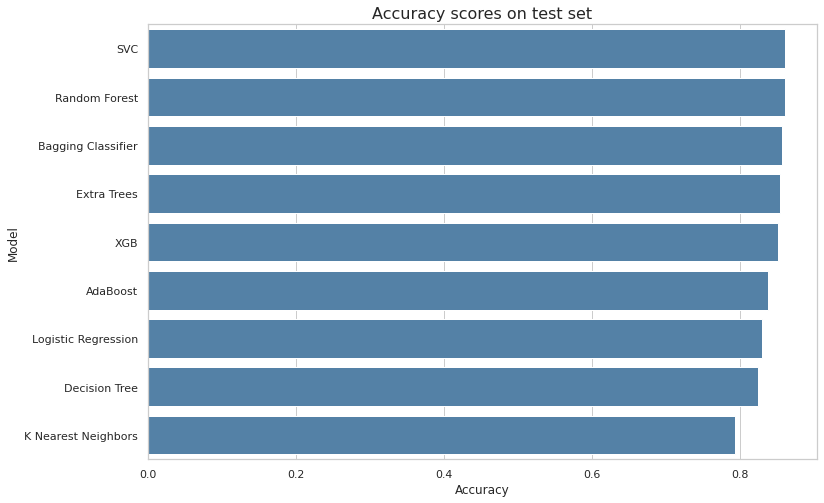

In [58]:
# Assessing the models' accuracy scores

# Linear model
lr_score = lr_model.score(X_test, y_test)

# Non-linear models
svc_score = svc_model.score(X_test, y_test)
knn_score = knn_model.score(X_test, y_test)
dt_score = dt_model.score(X_test, y_test)

# Ensemble learning models
rf_score = rf_model.score(X_test, y_test)
bc_score = bc_model.score(X_test, y_test)
et_score = et_model.score(X_test, y_test)
ab_score = ab_model.score(X_test, y_test)
xgb_score = xgb_model.score(X_test, y_test)

# Plotting the scores
labels = ['Logistic Regression', 'SVC', 'K Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Extra Trees', 'AdaBoost', 'XGB']
scores = [lr_score, svc_score, knn_score, dt_score, rf_score, bc_score, et_score, ab_score, xgb_score]
df_scores = pd.DataFrame(list(zip(labels, scores)), columns =['Model','Accuracy'])

plt.figure(figsize=(12, 8))
df_plot = sns.barplot(x='Accuracy', y='Model', data=df_scores, orient='h', color='steelblue', order=df_scores.sort_values('Accuracy',ascending=False).Model)
plt.title("Accuracy scores on test set", fontsize=16)

plt.show()

In [59]:
df_scores.sort_values(by="Accuracy", ascending=False)

,Model,Accuracy
1,SVC,0.861228
4,Random Forest,0.860807
5,Bagging Classifier,0.857443
6,Extra Trees,0.854079
8,XGB,0.851976
7,AdaBoost,0.837679
0,Logistic Regression,0.829268
3,Decision Tree,0.824643
2,K Nearest Neighbors,0.793524


### Tuning traditional ML models

Here, we choose the three best performing models from above for hyperparameter tuning.

In [60]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

# Setting the scorer to Accuracy as this is useful metric for classification problems.
scorer = make_scorer(accuracy_score)

**Defining hyperparameters**

In [61]:
# Defining ranges of hyperparameters to be randomly selected from
from scipy.stats import uniform

# SVC model
param_grid_svc = {"tol" : uniform(0.0005, 0.0045),
                  "gamma" : uniform(0.05, 0.1),
                  "cache_size" : list(range(100, 300)),
                  "C" : uniform(1, 19)}

# Random forest
param_grid_rf = {"n_estimators": list(range(100,500)),
                 "min_samples_split" : list(range(1,4)),
                 "max_features" : uniform(0.5, 0.5)}

# Bagging Classifier
param_grid_bc = {"max_features": uniform(0.5, 0.5),
                 "max_samples" : uniform(0.5, 0.5),
                 "n_estimators": list(range(100,500))}

**Performing randomized search**

In [62]:
# Support vector machines

# Defining parameters for RandomizedSearchCV
randsearch_obj_svc = RandomizedSearchCV(estimator=svc_model, 
                                        param_distributions=param_grid_svc,
                                        random_state=random_seed,
                                        n_iter=20,
                                        scoring=scorer,
                                        cv=3,
                                        n_jobs=-1)
# Fitting with data
randsearch_fit_svc = randsearch_obj_svc.fit(X_train, y_train)

# Defining best model
best_estimator_svc = randsearch_fit_svc.best_estimator_

In [63]:
# Random forest

# Defining parameters for RandomizedSearchCV

randsearch_obj_rf = RandomizedSearchCV(estimator=rf_model, 
                                        param_distributions=param_grid_rf,
                                        random_state=random_seed,
                                        n_iter=20,
                                        scoring=scorer,
                                        cv=3,
                                        n_jobs=-1)

# Fitting with data
randsearch_fit_rf = randsearch_obj_rf.fit(X_train, y_train)

# Defining best model
best_estimator_rf = randsearch_fit_rf.best_estimator_

In [64]:
# Bagging Classifier

# Defining parameters for RandomizedSearchCV
randsearch_obj_bc = RandomizedSearchCV(estimator=bc_model, 
                                        param_distributions=param_grid_bc,
                                        random_state=random_seed,
                                        n_iter=20,
                                        scoring=scorer,
                                        cv=3,
                                        n_jobs=-1)

# Fitting with data
randsearch_fit_bc = randsearch_obj_bc.fit(X_train, y_train)

# Defining best model
best_estimator_bc = randsearch_fit_bc.best_estimator_

### Selecting the best model

In [65]:
# Comparing results of randomized search

best_score_svc = best_estimator_svc.score(X_test, y_test)
best_score_rf = best_estimator_rf.score(X_test, y_test)
best_score_bc = best_estimator_bc.score(X_test, y_test)

best_params_svc = {key : round(randsearch_fit_svc.best_params_[key], 3) for key in randsearch_fit_svc.best_params_} 
best_params_rf = {key : round(randsearch_fit_rf.best_params_[key], 3) for key in randsearch_fit_rf.best_params_}
best_params_bc = {key : round(randsearch_fit_bc.best_params_[key], 3) for key in randsearch_fit_bc.best_params_}

pre_scores = [svc_score, rf_score, bc_score]
new_scores = [best_score_svc, best_score_rf, best_score_bc]
best_parameters = [best_params_svc, best_params_rf, best_params_bc]
df_new_scores = pd.DataFrame(list(zip(pre_scores, new_scores, best_parameters)), index =['SVC', 'Random Forest', 'Bagging Classifier'], 
               columns =['Accuracy before tuning', 'Accuracy after tuning', 'Best parameters'])
pd.set_option('display.max_colwidth', -1)
df_new_scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,Accuracy before tuning,Accuracy after tuning,Best parameters
SVC,0.861228,0.863331,"{'C': 3.823, 'cache_size': 280, 'gamma': 0.062, 'tol': 0.004}"
Random Forest,0.860807,0.876367,"{'max_features': 0.51, 'min_samples_split': 2, 'n_estimators': 434}"
Bagging Classifier,0.857443,0.870900,"{'max_features': 0.763, 'max_samples': 0.574, 'n_estimators': 454}"


As is evident above, Random Forest performs better than the other models. Therefore, we will continue with this model in the following.

## Neural networks

### Multi-layer perceptron (MLP)

#### MLP: Baseline model

In [66]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.pipeline import Pipeline

In [67]:
# Checking size of target and features
print("X:" + str(X.shape))
print("y:" + str(y.shape))

X:(11890, 445)
y:(11890,)


In [68]:
# Define baseline MLP model

reset_seeds() # Reset and set seed

baseline_model_mlp = Sequential(name="baseline_model_mlp") # Initialize sequential model
baseline_model_mlp.add(Input(shape=(X.shape[1],), name="input")) # Define input layer
baseline_model_mlp.add(Dense(200, activation="relu", name="hidden_0")) # Add one hidden layer with 200 neurons
baseline_model_mlp.add(Dense(1, activation="sigmoid", name="output")) # Output layer
baseline_model_mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) # Compile model

In [69]:
# Fit baseline model and show each epoch run
t = time.time()
history_mlp = baseline_model_mlp.fit(X_train, y_train, epochs=10, batch_size=5, verbose=1, validation_split=0.2, shuffle=True)

elapsed_time = time.time()-t
print("=== Training took {0:.2f} seconds ===".format(elapsed_time))

Epoch 1/10
1522/1522 [==============================] - 4s 2ms/step - loss: 0.3820 - accuracy: 0.8177 - val_loss: 0.3434 - val_accuracy: 0.8245
Epoch 2/10
1522/1522 [==============================] - 4s 2ms/step - loss: 0.3107 - accuracy: 0.8560 - val_loss: 0.3400 - val_accuracy: 0.8360
Epoch 3/10
1522/1522 [==============================] - 4s 2ms/step - loss: 0.2838 - accuracy: 0.8641 - val_loss: 0.3293 - val_accuracy: 0.8481
Epoch 4/10
1522/1522 [==============================] - 4s 2ms/step - loss: 0.2580 - accuracy: 0.8828 - val_loss: 0.3410 - val_accuracy: 0.8418
Epoch 5/10
1522/1522 [==============================] - 4s 2ms/step - loss: 0.2384 - accuracy: 0.8951 - val_loss: 0.3562 - val_accuracy: 0.8339
Epoch 6/10
1522/1522 [==============================] - 4s 2ms/step - loss: 0.2187 - accuracy: 0.9021 - val_loss: 0.3445 - val_accuracy: 0.8476
Epoch 7/10
1522/1522 [==============================] - 4s 2ms/step - loss: 0.1971 - accuracy: 0.9129 - val_loss: 0.3630 - val_accuracy:

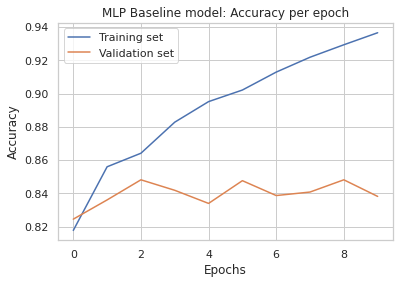

In [70]:
# Show accuracy history per epoch
plt.plot(history_mlp.history["accuracy"])
plt.plot(history_mlp.history["val_accuracy"])
plt.title("MLP Baseline model: Accuracy per epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Training set", "Validation set"], loc="upper left")
plt.show()

In [71]:
# See performance of baseline model on test set
accuracy_mlp_baseline = baseline_model_mlp.evaluate(X_test, y_test, return_dict=True)["accuracy"]
accuracy_mlp_baseline

75/75 [==============================] - 0s 1ms/step - loss: 0.3894 - accuracy: 0.8385


0.8385197520256042

In [72]:
# Show model summary
baseline_model_mlp.summary()

Model: "baseline_model_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 200)               89200     
_________________________________________________________________
output (Dense)               (None, 1)                 201       
Total params: 89,401
Trainable params: 89,401
Non-trainable params: 0
_________________________________________________________________


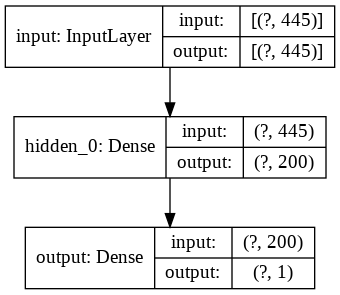

In [73]:
# Plot model architecture
tf.keras.utils.plot_model(baseline_model_mlp, show_shapes=True, show_layer_names=True, rankdir="TB", expand_nested=False, dpi=96)

#### MLP: Tuned model

In [74]:
# Make an MLP model that is ready to be tuned

def tuned_model_mlp(
    neurons=200,
    neurons_multiplier=0.5,
    hidden_layers=1,
    hidden_activation="relu",
    output_activation="sigmoid",
    n_outputs=1,
    kernel_initializer="glorot_uniform",
    optimizer="adam",
    loss="binary_crossentropy",
    **kwargs):

    reset_seeds() # Reset and set seed

    model_seq = Sequential(name="tuned_model_mlp")

    # Input layer
    model_seq.add(Input(shape=(X.shape[1],), name="input"))

    # Add x numbers of hidden layers
    for i in range(hidden_layers):

        # On first run, use defined no. of neurons. On subsequent, multiply by multiplier
        if i == 0:
          neurons_run = neurons
        else:
          neurons_run = round(neurons_run * neurons_multiplier)

        # Add one hidden layer
        layer_name = "hidden_" + str(i)
        model_seq.add(Dense(neurons_run, activation=hidden_activation, kernel_initializer=kernel_initializer, name=layer_name))

    # Add output layer
    model_seq.add(Dense(n_outputs, activation=output_activation, name="output"))

    # Compile model
    model_seq.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    return model_seq

In [75]:
# Initialize KerasClassifier on the basis of tuned model defined above
mlp_model = KerasClassifier(build_fn=tuned_model_mlp, epochs=10, batch_size=5, verbose=1, validation_split=0.2, shuffle=True)

In [76]:
# Draw random samples from a uniform distribution between 0.4 and 1.1
reset_seeds()
rand_draw = np.random.uniform(0.4, 1.1, 20).tolist()

In [77]:
# Tune over the following hyperparameter grid

param_grid_mlp = {
    "neurons": list(range(210, 230)),
    "neurons_multiplier": rand_draw, 
    "hidden_layers": list(range(0, 3)),
    "hidden_activation": ["relu", "selu", "elu"],
    "output_activation": ["sigmoid"],
    "n_outputs": [1],
    "kernel_initializer": ["glorot_uniform"],
    "epochs": list(range(3, 10)),
    "batch_size": list(range(5, 10)),
    "optimizer": ["adam", "rmsprop"],
    "loss": ["binary_crossentropy"]
}

In [78]:
# Initialize randomized search
randsearch_obj_mlp = RandomizedSearchCV(
    estimator=mlp_model,
    param_distributions=param_grid_mlp,
    random_state=random_seed,
    n_iter=20,
    scoring=scorer,
    cv=3,
    n_jobs=-1)

In [79]:
# Run randomized search
t = time.time()
randsearch_fit_mlp = randsearch_obj_mlp.fit(X_train, y_train)

elapsed_time = time.time()-t
print("=== Search took {0:.2f} seconds ===".format(elapsed_time))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Epoch 1/4
846/846 [==============================] - 2s 3ms/step - loss: 0.3861 - accuracy: 0.8182 - val_loss: 0.3406 - val_accuracy: 0.8345
Epoch 2/4
846/846 [==============================] - 2s 3ms/step - loss: 0.3338 - accuracy: 0.8473 - val_loss: 0.3445 - val_accuracy: 0.8429
Epoch 3/4
846/846 [==============================] - 2s 3ms/step - loss: 0.3215 - accuracy: 0.8591 - val_loss: 0.3452 - val_accuracy: 0.8418
Epoch 4/4
846/846 [==============================] - 2s 3ms/step - loss: 0.3082 - accuracy: 0.8694 - val_loss: 0.3403 - val_accuracy: 0.8424
=== Search took 534.51 seconds ===


In [80]:
# Define best parameters
best_params_mlp = randsearch_fit_mlp.best_params_
best_params_mlp

{'batch_size': 9,
 'epochs': 4,
 'hidden_activation': 'relu',
 'hidden_layers': 2,
 'kernel_initializer': 'glorot_uniform',
 'loss': 'binary_crossentropy',
 'n_outputs': 1,
 'neurons': 218,
 'neurons_multiplier': 0.520358708912816,
 'optimizer': 'rmsprop',
 'output_activation': 'sigmoid'}

In [81]:
# Define the best model from our MLP tuning
best_fit_mlp = randsearch_fit_mlp.best_estimator_

In [82]:
# Define predictions and probabilities for tuned MLP model
y_train_pred_mlp = best_fit_mlp.predict(X_train)
y_train_pred_proba_mlp = best_fit_mlp.predict_proba(X_train)[:, 1]

y_test_pred_mlp = best_fit_mlp.predict(X_test)
y_test_pred_proba_mlp = best_fit_mlp.predict_proba(X_test)[:, 1]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
1057/1057 [==============================] - 1s 907us/step
Instructions for updating:
Please use `model.predict()` instead.
265/265 [==============================] - 0s 876us/step


In [83]:
# Show accuracy score for tuned MLP on test set
accuracy_mlp_tuned = accuracy_score(y_test, y_test_pred_mlp)
accuracy_mlp_tuned

0.8456686291000841

### Convolutional Network (CNN)

In [84]:
from keras.models import Model
from keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, Flatten
from keras.layers.core import Reshape

#### CNN: Baseline model

To make a convolutional network, we need to reshape the data to a 3-dimensional form:
* Previous format: (cols, rows)
* New format: (cols, rows, 1)

In [85]:
# Define baseline CNN model

reset_seeds() # Reset and set seed

baseline_model_cnn = Sequential(name="baseline_model_cnn") # Initialize sequential model

baseline_model_cnn.add(Reshape((X.shape[1], 1), input_shape=(X.shape[1], ), name="input_reshape")) # Reshape data from 2D to 3D
baseline_model_cnn.add(Conv1D(filters=200, kernel_size=3, activation="relu", name="convolutional_0")) # Add a convolutional layer
baseline_model_cnn.add(MaxPool1D(pool_size=2, name="pooling")) # Add a pooling layer
baseline_model_cnn.add(Flatten(name="flatten")) # Flatten vector
baseline_model_cnn.add(Dense(1, activation="sigmoid", name="output")) # Output layer
baseline_model_cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) # Compile model

In [86]:
# Fit baseline model and show each epoch run
t = time.time()
history_cnn = baseline_model_cnn.fit(X_train, y_train, epochs=10, batch_size=5, verbose=1, validation_split=0.2, shuffle=True)

elapsed_time = time.time()-t
print("=== Training took {0:.2f} seconds ===".format(elapsed_time))

Epoch 1/10
1522/1522 [==============================] - 4s 3ms/step - loss: 0.4153 - accuracy: 0.8018 - val_loss: 0.3868 - val_accuracy: 0.8108
Epoch 2/10
1522/1522 [==============================] - 4s 3ms/step - loss: 0.3720 - accuracy: 0.8257 - val_loss: 0.4030 - val_accuracy: 0.8150
Epoch 3/10
1522/1522 [==============================] - 4s 3ms/step - loss: 0.3613 - accuracy: 0.8289 - val_loss: 0.3810 - val_accuracy: 0.8203
Epoch 4/10
1522/1522 [==============================] - 4s 3ms/step - loss: 0.3526 - accuracy: 0.8399 - val_loss: 0.3803 - val_accuracy: 0.8161
Epoch 5/10
1522/1522 [==============================] - 4s 3ms/step - loss: 0.3468 - accuracy: 0.8461 - val_loss: 0.3821 - val_accuracy: 0.8271
Epoch 6/10
1522/1522 [==============================] - 4s 3ms/step - loss: 0.3430 - accuracy: 0.8424 - val_loss: 0.3783 - val_accuracy: 0.8124
Epoch 7/10
1522/1522 [==============================] - 4s 3ms/step - loss: 0.3407 - accuracy: 0.8432 - val_loss: 0.3749 - val_accuracy:

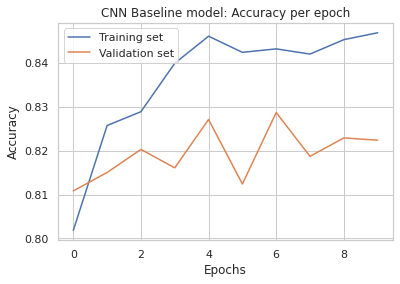

In [87]:
# Show accuracy history per epoch
plt.plot(history_cnn.history["accuracy"])
plt.plot(history_cnn.history["val_accuracy"])
plt.title("CNN Baseline model: Accuracy per epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Training set", "Validation set"], loc="upper left")
plt.show()

In [88]:
# See performance of baseline model on test set
accuracy_cnn_baseline = baseline_model_cnn.evaluate(X_test, y_test, return_dict=True)["accuracy"]
accuracy_cnn_baseline

75/75 [==============================] - 0s 2ms/step - loss: 0.3558 - accuracy: 0.8238


0.8238015174865723

In [89]:
# Show model summary
baseline_model_cnn.summary()

Model: "baseline_model_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_reshape (Reshape)      (None, 445, 1)            0         
_________________________________________________________________
convolutional_0 (Conv1D)     (None, 443, 200)          800       
_________________________________________________________________
pooling (MaxPooling1D)       (None, 221, 200)          0         
_________________________________________________________________
flatten (Flatten)            (None, 44200)             0         
_________________________________________________________________
output (Dense)               (None, 1)                 44201     
Total params: 45,001
Trainable params: 45,001
Non-trainable params: 0
_________________________________________________________________


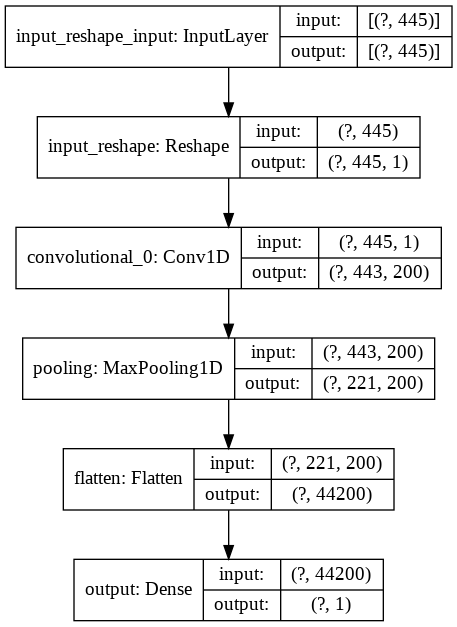

In [90]:
# Plot model architecture
tf.keras.utils.plot_model(baseline_model_cnn, show_shapes=True, show_layer_names=True, rankdir="TB", expand_nested=False, dpi=96)

#### CNN: Tuned model

In [144]:
# Make a CNN model that is ready to be tuned

def tuned_model_cnn(conv_layers=1,
                    filters=200,
                    filters_multiplier=2,
                    kernel_size=3,
                    kernel_initializer="glorot_uniform",
                    pool_method="MaxPool1D",
                    pool_size=2,
                    hidden_layers=1,
                    neurons="filters_increment",
                    neurons_multiplier="filters_multiplier",
                    conv_activation="relu",
                    hidden_activation="relu",
                    output_activation="sigmoid",
                    n_outputs=1,
                    optimizer="adam",
                    loss="binary_crossentropy",
                    **kwargs):
  
  model_seq = Sequential(name="tuned_model_cnn")
  model_seq.add(Reshape((X.shape[1], 1), input_shape=(X.shape[1], ), name="input_reshape")) # Reshape data

  # Min. 1 convolutional layer
  if conv_layers < 1:
    conv_layers = 1
  
  # Add x numbers of convolutional layers with x filters and x filter increments
  for i in range(conv_layers):
    if i == 0:
      filters_run = filters
    else:
      filters_run = round(filters_run * filters_multiplier)
    
    conv_layer_name = "convolutional_" + str(i)
    model_seq.add(Conv1D(filters=filters_run, kernel_size=kernel_size, activation=conv_activation, kernel_initializer=kernel_initializer, name=conv_layer_name))

  # Add pooling layer
  if pool_method == "AveragePooling1D":
    model_seq.add(AveragePooling1D(pool_size=pool_size))
  else:
    model_seq.add(MaxPool1D(pool_size=pool_size))
  
  model_seq.add(Flatten()) # Flatten vector

  # Determine neuron multiplier (increments)
  if neurons_multiplier == "filters_multiplier":
    multiplier = filters_multiplier
  else:
    multiplier = neurons_multiplier
  
  # Add x numbers of hidden layers with x neurons and x neuron increments
  for i in range(hidden_layers):
    if i == 0:
      if neurons == "filters_increment":
        neurons_run = round(filters_run * multiplier)
      else:
        neurons_run = neurons
    else:
      neurons_run = round(neurons_run * multiplier)
    
    # Add one hidden layer
    hidden_layer_name = "hidden_" + str(i)
    model_seq.add(Dense(neurons_run, activation=hidden_activation, kernel_initializer=kernel_initializer, name=hidden_layer_name))
  
  model_seq.add(Dense(n_outputs, activation=output_activation, name="output")) # Output layer
  model_seq.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"]) # Compile model

  return model_seq

In [145]:
# Initialize KerasClassifier on the basis of tuned model defined above
cnn_model = KerasClassifier(build_fn=tuned_model_cnn, epochs=10, batch_size=5, verbose=1, validation_split=0.2, shuffle=True)

In [146]:
# Draw random samples from a uniform distribution between 0.4 and 1.1
reset_seeds()
rand_draw = np.random.uniform(0.4, 1.1, 20).tolist()

In [147]:
# Tune over the following hyperparameter grid

param_grid_cnn = {
    "conv_layers": list(range(1, 4)),
    "filters": list(range(180, 250)),
    "filters_multiplier": rand_draw,
    "kernel_size": list(range(1, 5)),
    "pool_method": ["MaxPool1D", "AveragePooling1D"],
    "pool_size": [2],
    "hidden_layers": list(range(0, 3)),
    "neurons": ["filters_increment"],
    "neurons_multiplier": ["filters_multiplier"],
    "conv_activation": ["relu", "selu", "elu"],
    "hidden_activation": ["relu", "selu", "elu"],
    "output_activation": ["sigmoid"],
    "n_outputs": [1],
    "kernel_initializer": ["glorot_uniform"],
    "epochs": list(range(3, 12)),
    "batch_size": list(range(5, 10)),
    "optimizer": ["adam", "rmsprop"],
    "loss": ["binary_crossentropy"]
}

In [148]:
# Initialize randomized search
randsearch_obj_cnn = RandomizedSearchCV(estimator=cnn_model, param_distributions=param_grid_cnn, random_state=random_seed, n_iter=20, scoring=scorer, cv=3, n_jobs=-1)

In [149]:
# Run randomized search
t = time.time()
randsearch_fit_cnn = randsearch_obj_cnn.fit(X_train, y_train)

elapsed_time = time.time()-t
print("=== Search took {0:.2f} seconds ===".format(elapsed_time))

Epoch 1/4
1269/1269 [==============================] - 6s 4ms/step - loss: 0.4390 - accuracy: 0.7964 - val_loss: 0.3861 - val_accuracy: 0.8082
Epoch 2/4
1269/1269 [==============================] - 5s 4ms/step - loss: 0.3837 - accuracy: 0.8185 - val_loss: 0.4084 - val_accuracy: 0.8140
Epoch 3/4
1269/1269 [==============================] - 5s 4ms/step - loss: 0.3719 - accuracy: 0.8270 - val_loss: 0.4096 - val_accuracy: 0.8145
Epoch 4/4
1269/1269 [==============================] - 5s 4ms/step - loss: 0.3589 - accuracy: 0.8373 - val_loss: 0.3747 - val_accuracy: 0.8203
=== Search took 686.65 seconds ===


In [150]:
# Define best parameters
best_params_cnn = randsearch_fit_cnn.best_params_

In [151]:
# Show best parameters
best_params_cnn

{'batch_size': 6,
 'conv_activation': 'relu',
 'conv_layers': 3,
 'epochs': 4,
 'filters': 217,
 'filters_multiplier': 0.48509838454818,
 'hidden_activation': 'selu',
 'hidden_layers': 1,
 'kernel_initializer': 'glorot_uniform',
 'kernel_size': 4,
 'loss': 'binary_crossentropy',
 'n_outputs': 1,
 'neurons': 'filters_increment',
 'neurons_multiplier': 'filters_multiplier',
 'optimizer': 'rmsprop',
 'output_activation': 'sigmoid',
 'pool_method': 'MaxPool1D',
 'pool_size': 2}

In [152]:
# Define the best model from our CNN tuning
best_fit_cnn = randsearch_fit_cnn.best_estimator_

In [153]:
# Reshape training and test sets to 3D
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)

In [154]:
X_test_reshaped.shape

(2378, 445, 1)

In [155]:
# Define predictions and probabilities for tuned CNN model
y_train_pred_cnn = best_fit_cnn.predict(X_train_reshaped)
y_train_pred_proba_cnn = best_fit_cnn.predict_proba(X_train_reshaped)[:, 1]

y_test_pred_cnn = best_fit_cnn.predict(X_test_reshaped)
y_test_pred_proba_cnn = best_fit_cnn.predict_proba(X_test_reshaped)[:, 1]

397/397 [==============================] - 1s 1ms/step


In [156]:
# Show accuracy score for tuned CNN on test set
accuracy_cnn_tuned = accuracy_score(y_test, y_test_pred_cnn)
accuracy_cnn_tuned

0.8368376787216149

### Selecting the best network

In [157]:
# Comparing results of randomized search

baseline_scores = [accuracy_mlp_baseline, accuracy_cnn_baseline]
tuned_scores = [accuracy_mlp_tuned, accuracy_cnn_tuned]
tuned_params = [best_params_mlp, best_params_cnn]

df_neural_scores = pd.DataFrame(list(zip(baseline_scores, tuned_scores, tuned_params)), index =["MLP", "CNN"], 
                columns =["Accuracy: Baseline model", "Accuracy: Tuned model", "Best parameters"])
pd.set_option('display.max_colwidth', -1)
df_neural_scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,Accuracy: Baseline model,Accuracy: Tuned model,Best parameters
MLP,0.838520,0.845669,"{'output_activation': 'sigmoid', 'optimizer': 'rmsprop', 'neurons_multiplier': 0.520358708912816, 'neurons': 218, 'n_outputs': 1, 'loss': 'binary_crossentropy', 'kernel_initializer': 'glorot_uniform', 'hidden_layers': 2, 'hidden_activation': 'relu', 'epochs': 4, 'batch_size': 9}"
CNN,0.823802,0.836838,"{'pool_size': 2, 'pool_method': 'MaxPool1D', 'output_activation': 'sigmoid', 'optimizer': 'rmsprop', 'neurons_multiplier': 'filters_multiplier', 'neurons': 'filters_increment', 'n_outputs': 1, 'loss': 'binary_crossentropy', 'kernel_size': 4, 'kernel_initializer': 'glorot_uniform', 'hidden_layers': 1, 'hidden_activation': 'selu', 'filters_multiplier': 0.48509838454818, 'filters': 217, 'epochs': 4, 'conv_layers': 3, 'conv_activation': 'relu', 'batch_size': 6}"


### Checking for an preventing overfitting

In [106]:
# Initialize tuned MLP model with best parameters
best_model_mlp = tuned_model_mlp(**best_params_mlp)

In [107]:
# Fit tuned MLP model with best parameters and show each epoch run
t = time.time()
history_best_mlp = best_model_mlp.fit(X_train, y_train, epochs=best_params_mlp["epochs"], batch_size=best_params_mlp["batch_size"], verbose=1, validation_split=0.2, shuffle=True)

elapsed_time = time.time()-t
print("=== Training took {0:.2f} seconds ===".format(elapsed_time))

Epoch 1/4
846/846 [==============================] - 3s 3ms/step - loss: 0.3861 - accuracy: 0.8182 - val_loss: 0.3406 - val_accuracy: 0.8345
Epoch 2/4
846/846 [==============================] - 2s 3ms/step - loss: 0.3338 - accuracy: 0.8473 - val_loss: 0.3445 - val_accuracy: 0.8429
Epoch 3/4
846/846 [==============================] - 2s 3ms/step - loss: 0.3215 - accuracy: 0.8591 - val_loss: 0.3452 - val_accuracy: 0.8418
Epoch 4/4
846/846 [==============================] - 2s 3ms/step - loss: 0.3082 - accuracy: 0.8694 - val_loss: 0.3403 - val_accuracy: 0.8424
=== Training took 9.98 seconds ===


In [108]:
# Show a summary of the model - including number of trainable parameters
best_model_mlp.summary()

Model: "tuned_model_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 218)               97228     
_________________________________________________________________
hidden_1 (Dense)             (None, 113)               24747     
_________________________________________________________________
output (Dense)               (None, 1)                 114       
Total params: 122,089
Trainable params: 122,089
Non-trainable params: 0
_________________________________________________________________


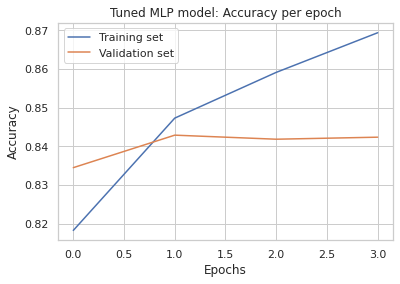

In [109]:
# Show accuracy history per epoch
plt.plot(history_best_mlp.history["accuracy"])
plt.plot(history_best_mlp.history["val_accuracy"])
plt.title("Tuned MLP model: Accuracy per epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Training set", "Validation set"], loc="upper left")
plt.show()

**Add regularization techniques**

In [110]:
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

In [111]:
# Show best parameters to make model below
best_params_mlp

{'batch_size': 9,
 'epochs': 4,
 'hidden_activation': 'relu',
 'hidden_layers': 2,
 'kernel_initializer': 'glorot_uniform',
 'loss': 'binary_crossentropy',
 'n_outputs': 1,
 'neurons': 218,
 'neurons_multiplier': 0.520358708912816,
 'optimizer': 'rmsprop',
 'output_activation': 'sigmoid'}

In [112]:
# Define custom MLP model (roughly based on best parameters from tuning)
# This time with regularization techniques

reset_seeds() # Reset and set seed

regularized_model_mlp = Sequential(name="regularized_model_mlp") # Initialize sequential model
regularized_model_mlp.add(Input(shape=(X.shape[1],), name="input")) # Define input layer
regularized_model_mlp.add(Dense(218, activation="relu", name="hidden_0")) # Hidden layer
regularized_model_mlp.add(Dropout(0.4, name="dropout_0")) # Add a dropout layer
regularized_model_mlp.add(Dense(218*0.52, activation="relu", name="hidden_1")) # Hidden layer
regularized_model_mlp.add(Dropout(0.4, name="dropout_1")) # Add a dropout layer
regularized_model_mlp.add(Dense(1, activation="sigmoid", name="output")) # Output layer
regularized_model_mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) # Compile model

In [113]:
# Fit baseline model and show each epoch run
t = time.time()
history_reg_mlp = regularized_model_mlp.fit(X_train, y_train, epochs=4, batch_size=9, verbose=1, validation_split=0.2, shuffle=True)

elapsed_time = time.time()-t
print("=== Training took {0:.2f} seconds ===".format(elapsed_time))

Epoch 1/4
846/846 [==============================] - 2s 3ms/step - loss: 0.4104 - accuracy: 0.8009 - val_loss: 0.3449 - val_accuracy: 0.8303
Epoch 2/4
846/846 [==============================] - 2s 3ms/step - loss: 0.3400 - accuracy: 0.8439 - val_loss: 0.3330 - val_accuracy: 0.8360
Epoch 3/4
846/846 [==============================] - 2s 3ms/step - loss: 0.3135 - accuracy: 0.8537 - val_loss: 0.3348 - val_accuracy: 0.8387
Epoch 4/4
846/846 [==============================] - 2s 3ms/step - loss: 0.2935 - accuracy: 0.8661 - val_loss: 0.3245 - val_accuracy: 0.8376
=== Training took 9.53 seconds ===


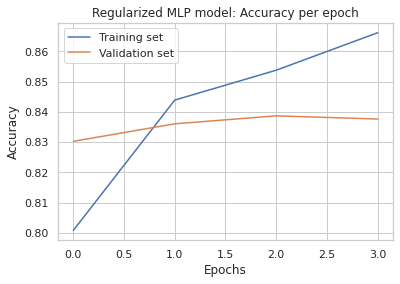

In [114]:
# Show accuracy history per epoch
plt.plot(history_reg_mlp.history["accuracy"])
plt.plot(history_reg_mlp.history["val_accuracy"])
plt.title("Regularized MLP model: Accuracy per epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Training set", "Validation set"], loc="upper left")
plt.show()

In [115]:
# See performance of baseline model on test set
accuracy_mlp_baseline = baseline_model_mlp.evaluate(X_test, y_test, return_dict=True)["accuracy"]
accuracy_mlp_baseline

75/75 [==============================] - 0s 2ms/step - loss: 0.3894 - accuracy: 0.8385


0.8385197520256042

# Evaluate model performance

**Define predictions and probabilities for the two models**

In [116]:
# Define predictions and probabilities for Random Forest model
y_train_pred_rf = best_estimator_rf.predict(X_train)
y_train_pred_proba_rf = best_estimator_rf.predict_proba(X_train)[:, 1]

y_test_pred_rf = best_estimator_rf.predict(X_test)
y_test_pred_proba_rf = best_estimator_rf.predict_proba(X_test)[:, 1]

In [117]:
# Predictions and probabilities for MLP defined further above (in its own section)

## Confusion matrix

We will plot a confusion matrix for each model to get an inital overview of their predictions

In [118]:
# Import the class confusion_matrix
from sklearn.metrics import confusion_matrix

# Import the confusion matrix plotter module
from mlxtend.plotting import plot_confusion_matrix

# Make arrays with confusion matrix for the two models
cm_log_rf = confusion_matrix(y_test, y_test_pred_rf)
cm_log_mlp = confusion_matrix(y_test, y_test_pred_mlp)

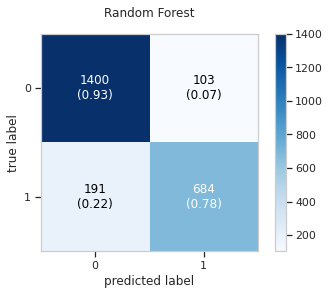

In [119]:
# Plot the confusion matrix for Random Forest model
fig, ax = plot_confusion_matrix(cm_log_rf, show_absolute=True, show_normed=True, colorbar=True)
ax.set_title("Random Forest")

fig.show()

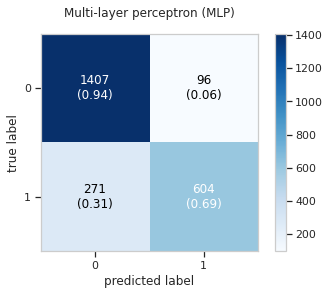

In [120]:
# Plot the confusion matrix for MLP model
fig, ax = plot_confusion_matrix(cm_log_mlp, show_absolute=True, show_normed=True, colorbar=True)
ax.set_title("Multi-layer perceptron (MLP)")

fig.show()

## Classification report

We will examine the accuracy, recall, precision and F1 scores for each model based on a classification report

**Classification report**

In [121]:
from sklearn.metrics import classification_report
 
# Random Forest
print("Random Forest:")
print(classification_report(y_test, y_test_pred_rf))
print("================\n")

# MLP
print("Multi-layer perceptron (MLP):")
print(classification_report(y_test, y_test_pred_mlp))

Random Forest:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1503
           1       0.87      0.78      0.82       875

    accuracy                           0.88      2378
   macro avg       0.87      0.86      0.86      2378
weighted avg       0.88      0.88      0.87      2378


Multi-layer perceptron (MLP):
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      1503
           1       0.86      0.69      0.77       875

    accuracy                           0.85      2378
   macro avg       0.85      0.81      0.83      2378
weighted avg       0.85      0.85      0.84      2378



**Visualizing the scores**

In [122]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Random Forest scores
rf_accuracy = accuracy_score(y_test, y_test_pred_rf)
rf_precision = precision_score(y_test, y_test_pred_rf, average="macro")
rf_recall = recall_score(y_test, y_test_pred_rf, average="macro")
rf_f1score = f1_score(y_test, y_test_pred_rf)

# MLP scores
mlp_accuracy = accuracy_score(y_test, y_test_pred_mlp)
mlp_precision = precision_score(y_test, y_test_pred_mlp, average="macro")
mlp_recall = recall_score(y_test, y_test_pred_mlp, average="macro")
mlp_f1score = f1_score(y_test, y_test_pred_mlp)

accuracy = [rf_accuracy, mlp_accuracy]
recall = [rf_recall, mlp_recall ]
precision = [rf_precision, mlp_precision]
f1_score = [rf_f1score, mlp_f1score]

df_metric = pd.DataFrame(list(zip(accuracy, recall, precision, f1_score)), index =['Random Forest', 'MLP'], 
               columns =['Accuracy', 'Recall', 'Precision', 'F1 score'])
pd.set_option('display.max_colwidth', -1)
df_metric.T

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,Random Forest,MLP
Accuracy,0.876367,0.845669
Recall,0.856592,0.813207
Precision,0.874536,0.850678
F1 score,0.823105,0.766984


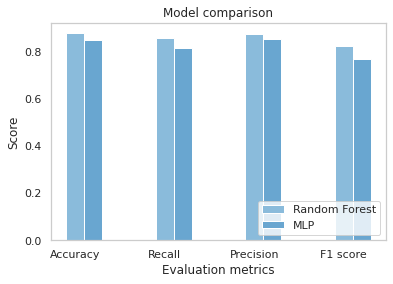

In [123]:
# Plotting the scores
sns.set(style="whitegrid", palette="Blues_d")
fig, ax = plt.subplots()

width = 0.2  # the width of the bars
labels = df_metric.columns
x = np.arange(len(labels))  # the label locations

ax.bar(x, df_metric.iloc[0, :], width, label="Random Forest")
ax.bar(x + width, df_metric.iloc[1, :], width, label="MLP")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Score")
ax.set_xlabel("Evaluation metrics")
ax.set_title("Model comparison")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.grid(b=None)
ax.legend(loc = 'lower right')

## ROC curves and AUC scores

Finally, we will plot ROC curves and calculate AUC scores to get an overview of how the models perform across different threshold levels and to check for over- or underfitting.

In [124]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, roc_auc_score

In [125]:
# Defining ROC curves and AUC scores for training and test sets

# Random Forest
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_train_pred_proba_rf)
auc_score_train_rf = roc_auc_score(y_train, y_train_pred_proba_rf)

fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_test_pred_proba_rf)
auc_score_test_rf = roc_auc_score(y_test, y_test_pred_proba_rf)

# MLP
fpr_train_mlp, tpr_train_mlp, _ = roc_curve(y_train, y_train_pred_proba_mlp)
auc_score_train_mlp = roc_auc_score(y_train, y_train_pred_proba_mlp)

fpr_test_mlp, tpr_test_mlp, _ = roc_curve(y_test, y_test_pred_proba_mlp)
auc_score_test_mlp = roc_auc_score(y_test, y_test_pred_proba_mlp)

In [126]:
# Plot ROC curves in a subplot with two columns

fig = make_subplots(rows=1, cols=2, subplot_titles=("Random Forest", "Multi-layer perceptron (MLP)"))

# Define legends for the two graphs
name_train_rf = f"Random Forest Train (AUC={auc_score_train_rf:.2f})"
name_test_rf = f"Random Forest Test (AUC={auc_score_test_rf:.2f})"
name_train_mlp = f"MLP Train (AUC={auc_score_train_mlp:.2f})"
name_test_mlp = f"MLP Test (AUC={auc_score_test_mlp:.2f})"

# Add ROC curve 1
fig.add_trace(go.Scatter(x=fpr_train_rf, y=tpr_train_rf, name=name_train_rf, mode="lines"), row=1, col=1)
fig.add_trace(go.Scatter(x=fpr_test_rf, y=tpr_test_rf, name=name_test_rf, mode="lines"), row=1, col=1)
fig.add_shape(row=1, col=1, type="line", line=dict(dash="dash"), x0=0, x1=1, y0=0, y1=1)

# Add ROC curve 2
fig.add_trace(go.Scatter(x=fpr_train_mlp, y=tpr_train_mlp, name=name_train_mlp, mode="lines"), row=1, col=2)
fig.add_trace(go.Scatter(x=fpr_test_mlp, y=tpr_test_mlp, name=name_test_mlp, mode="lines"), row=1, col=2)
fig.add_shape(row=1, col=2, type="line", line=dict(dash="dash"), x0=0, x1=1, y0=0, y1=1)

# Customize axes
fig.update_xaxes(title_text="False Positive Rate", range=[0, 1], row=1, col=1)
fig.update_yaxes(title_text="True Positive Rate", range=[0, 1], row=1, col=1)
fig.update_xaxes(title_text="False Positive Rate", range=[0, 1], row=1, col=2)
fig.update_yaxes(title_text="True Positive Rate", range=[0, 1], row=1, col=2)

# Show plot
fig.update_layout(title_text="ROC curves")
fig.show()

# Business insights

## Permutation feature importance

To extract business insights from the model, we will now find the permutation feature importance scores for the Random Forest model. To do so, we will need to refit the best estimator of our model on the ordinal encoded dataframe.

In [127]:
# Fit the best estimator of the Random Forest model on the OrdinalEncoded dataframe
rf_oe = best_estimator_rf.fit(X_fi_train, y_fi_train)

In [128]:
fi_best_model = permutation_importance(rf_oe, X_fi_train, y_fi_train, n_repeats=5, random_state=random_seed)

In [129]:
# Make a list of all features and their scores
feature_cols = []
feature_imp_mean = []
feature_imp_std = []

for i in fi_best_model.importances_mean.argsort()[::-1]:
  col = df_fi.columns[i]
  imp_mean = fi_best_model.importances_mean[i]
  imp_std = fi_best_model.importances_std[i]

  feature_cols.append(col)
  feature_imp_mean.append(imp_mean)
  feature_imp_std.append(imp_std)

In [130]:
# Display in a DF
feature_list = pd.DataFrame([feature_cols, feature_imp_mean, feature_imp_std]).T
feature_list.columns = ["Variable", "Feature permutation importance", "Std. dev."]
feature_list = feature_list.sort_values(by="Feature permutation importance", ascending=False)
feature_list.head(10)

,Variable,Feature permutation importance,Std. dev.
0,country,0.137216,0.002015
1,lead_time,0.124643,0.00334678
2,total_of_special_requests,0.111018,0.00207403
3,market_segment,0.0882254,0.00064943
4,deposit_type,0.0843146,0.00102791
5,agent,0.0808032,0.00232298
6,adr,0.0452691,0.00157148
7,arrival_date_week_number,0.0312237,0.000393362
8,previous_cancellations,0.029037,0.00109133
9,customer_type,0.0269554,0.00128173


## Exploratory data analysis

Based on some of the most important features as found above, we will now perform EDA on some of these features to identify what characterizes cancelled bookings.

In [131]:
# Make a copy of the original, cleaned dataframe
df_eda = df_modified.copy()

In [132]:
# Correct data types back for EDA
df_eda["is_canceled"] = df_eda["is_canceled"].astype("int64")

### Deposit type

In [133]:
# Create a DF containing the mean of is_canceled (i.e. the probability of cancellation) per deposit type
deposit_cancelrate = pd.DataFrame(df_eda.groupby(by="deposit_type")["is_canceled"].mean().sort_values(ascending=False))
deposit_cancelrate = deposit_cancelrate.reset_index()
deposit_cancelrate

,deposit_type,is_canceled
0,Non Refund,0.993618
1,No Deposit,0.284531
2,Refundable,0.222222


No handles with labels found to put in legend.


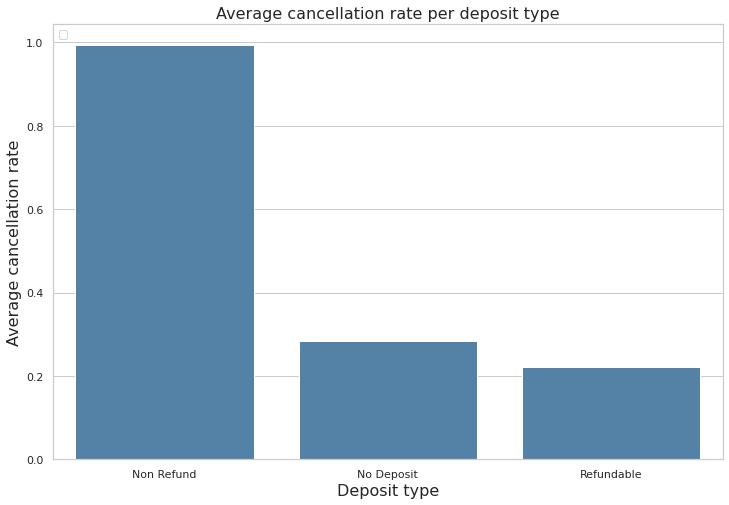

In [134]:
# Plot graph
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(12, 8))
sns.barplot(x='deposit_type',
            y="is_canceled",
            data=deposit_cancelrate,
            color="steelblue",
            ci=None)
plt.title("Average cancellation rate per deposit type", fontsize=16)
plt.xlabel("Deposit type", fontsize=16)
plt.ylabel("Average cancellation rate", fontsize=16)
plt.legend(loc="upper left")
plt.show()

### Home country

In [135]:
# Create a DF containing the mean of is_canceled (i.e. the probability of cancellation) per country
# We define a lower threshold for country count - otherwise put into "Other" category
country_threshold = round(0.005 * df_eda["country"].count())
df_eda["country_filtered"] = np.where(df_eda.groupby(by="country")["country"].transform("size") < country_threshold, "Other", df_eda["country"])
country_cancelrate = df_eda.groupby(by="country_filtered")["is_canceled"].mean().sort_values(ascending=False)
country_cancelrate = pd.DataFrame(country_cancelrate)
country_cancelrate = country_cancelrate.reset_index()
country_cancelrate["sort"] = 1
country_cancelrate.loc[country_cancelrate["country_filtered"] == "Other", "sort"] = 0
country_cancelrate = country_cancelrate.sort_values(by=["sort", "is_canceled"], ascending=False).reset_index(drop=True)
country_cancelrate

,country_filtered,is_canceled,sort
0,PRT,0.566327,1
1,RUS,0.378165,1
2,BRA,0.373201,1
3,ITA,0.353956,1
4,CHN,0.314311,1
5,NOR,0.298188,1
6,ESP,0.254085,1
7,ISR,0.252616,1
8,CHE,0.247399,1
9,IRL,0.246519,1


No handles with labels found to put in legend.


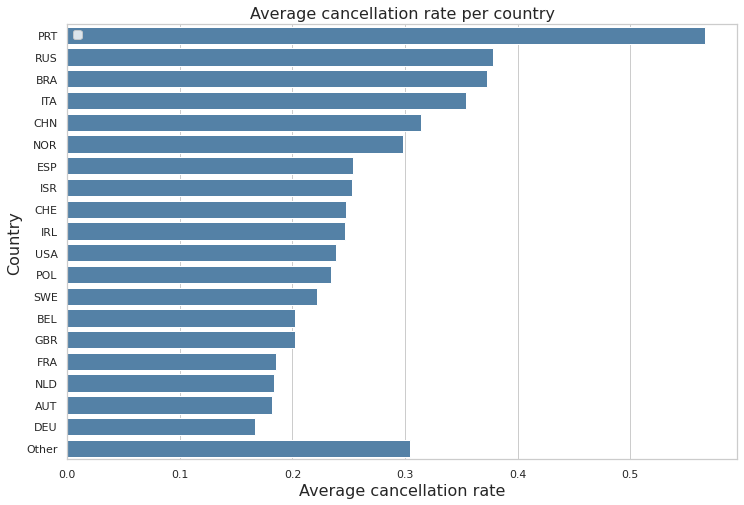

In [136]:
# Plot graph
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(12, 8))
sns.barplot(x="is_canceled",
            y="country_filtered",
            data=country_cancelrate,
            ci=None,
            color="steelblue",
            orient="h")
plt.title("Average cancellation rate per country", fontsize=16)
plt.xlabel("Average cancellation rate", fontsize=16)
plt.ylabel("Country", fontsize=16)
plt.legend(loc="upper left")
plt.show()

### Agent

#### Agent ID distribution

In [137]:
# Create a DF containing the distribution of agents
agent_dist = pd.DataFrame(df_eda["agent"].value_counts())
agent_dist = agent_dist.reset_index()
agent_dist.columns = ["agent_id", "count"]
agent_dist["is_agent"] = agent_dist["agent_id"].apply(lambda x: str("No agent") if x == "None" else str("Agent"))
agent_dist

,agent_id,count,is_agent
0,9,31959,Agent
1,None,16003,No agent
2,240,13871,Agent
3,1,7191,Agent
4,14,3638,Agent
...,...,...,...
328,472,1,Agent
329,197,1,Agent
330,73,1,Agent
331,216,1,Agent


In [138]:
# Plot this distribution in a pie chart
fig = px.sunburst(agent_dist, path=["is_agent", "agent_id"], values="count", title="Distribution of agent IDs", template="seaborn", color_discrete_sequence=px.colors.sequential.dense)
fig.update_traces(textinfo="value+percent entry+label")
fig.show()

#### Agent cancellation rates

In [139]:
# Create a DF containing the mean of is_canceled (i.e. the probability of cancellation) per agent ID
# Define threshold at top 10
agent_sort = agent_dist.sort_values(by="count", ascending=False)
agent_threshold = agent_sort.iloc[9, 1]
df_eda["agent_filtered"] = np.where(df_eda.groupby(by="agent")["agent"].transform("size") < agent_threshold, "Other", df_eda["agent"])
agent_cancelrate = pd.DataFrame(df_eda.groupby(by="agent_filtered")["is_canceled"].mean().sort_values(ascending=False))
agent_cancelrate = agent_cancelrate.reset_index()
agent_cancelrate = agent_cancelrate.rename(columns={"agent_filtered": "agent_id"})
agent_cancelrate = agent_cancelrate.merge(agent_dist, how="left", on="agent_id")
agent_cancelrate = agent_cancelrate.drop(columns="is_agent", axis=1)
agent_cancelrate.loc[agent_cancelrate["agent_id"] == "Other", "count"] = df_eda["agent"].count() - agent_cancelrate["count"].sum()
agent_cancelrate["sort"] = 2
agent_cancelrate.loc[agent_cancelrate["agent_id"] == "Other", "sort"] = 1
agent_cancelrate.loc[agent_cancelrate["agent_id"] == "None", "sort"] = 0
agent_cancelrate = agent_cancelrate.sort_values(by=["sort", "is_canceled"], ascending=False).reset_index(drop=True)
agent_cancelrate

,agent_id,is_canceled,count,sort
0,1,0.734251,7191.0,2
1,9,0.415000,31959.0,2
2,240,0.395357,13871.0,2
3,6,0.310691,3283.0,2
4,250,0.179685,2855.0,2
5,14,0.178944,3638.0,2
6,241,0.137369,1718.0,2
7,7,0.133936,3539.0,2
8,28,0.066026,1666.0,2
9,Other,0.395804,33173.0,1


No handles with labels found to put in legend.


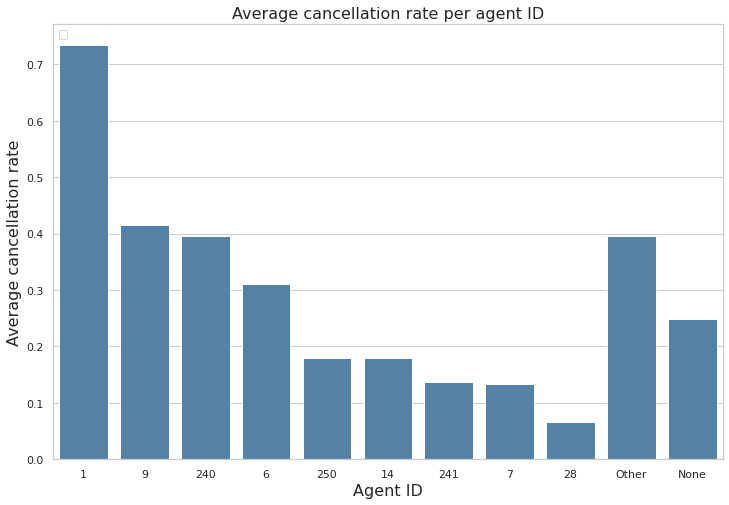

In [140]:
# Plot graph
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(12, 8))
sns.barplot(x="agent_id",
            y="is_canceled",
            data=agent_cancelrate,
            ci=None,
            color="steelblue")
plt.title("Average cancellation rate per agent ID", fontsize=16)
plt.xlabel("Agent ID", fontsize=16)
plt.ylabel("Average cancellation rate", fontsize=16)
plt.legend(loc="upper left")
plt.show()

### Lead time

In [141]:
# Create datapoints for scatterplot (using lead time and is_canceled mean)
leadtime_cancelrate = pd.DataFrame(df_eda.groupby(by="lead_time")["is_canceled"].mean().sort_values(ascending=False)).reset_index()
leadtime_cancelrate

,lead_time,is_canceled
0,387,1.0
1,403,1.0
2,489,1.0
3,482,1.0
4,412,1.0
...,...,...
474,460,0.0
475,463,0.0
476,532,0.0
477,542,0.0


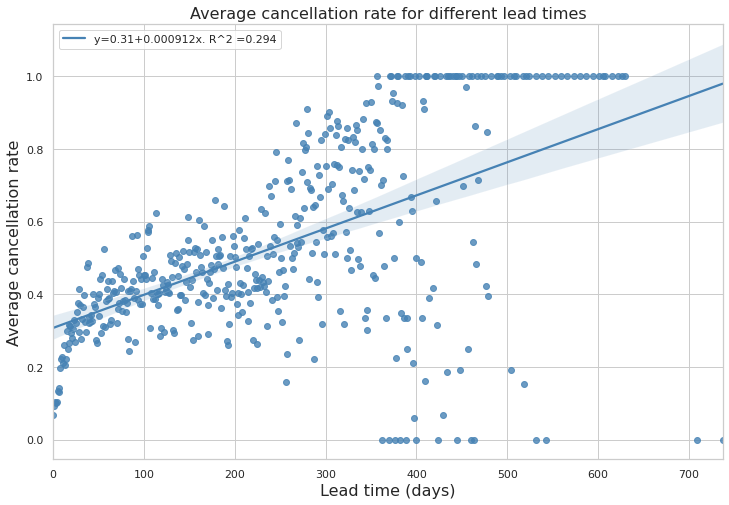

In [142]:
# Make a scatterplot of lead time and avg. cancellation rate and fit a regression line
sns.set(style="whitegrid", color_codes=True)
p = plt.figure(figsize=(12, 8))
p = sns.regplot(x="lead_time",
            y="is_canceled",
            fit_reg=True,
            color="steelblue",
            data=leadtime_cancelrate)
p = plt.title("Average cancellation rate for different lead times", fontsize=16)
p = plt.xlabel("Lead time (days)", fontsize=16)
p = plt.ylabel("Average cancellation rate", fontsize=16)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(leadtime_cancelrate["lead_time"], leadtime_cancelrate["is_canceled"])
equation = r"y={0:.2f}+{1:.6f}x. R^2 ={2:.3f}".format(intercept, slope, (r_value**2))
plt.legend(loc="upper left", labels=[equation])

plt.show()

In [143]:
# Print R-squared value of the regression above
print(r"R^2: {0:.4f}".format(r_value**2))

R^2: 0.2944
